In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split

sns.set(style='white', context='notebook', palette='deep')

In [10]:
data = pd.read_csv('preprocessed.csv')

In [11]:
X = data.drop(['Unnamed: 0', 'isLegendary'],1)

In [12]:
y = data['isLegendary']

In [17]:
X_train, X_test, Y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify = y)

In [38]:
data.columns

Index(['Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk',
       'Sp_Def', 'Speed', 'Generation', 'isLegendary', 'Color', 'hasGender',
       'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'hasMegaEvolution', 'Height_m',
       'Weight_kg', 'Catch_Rate', 'Body_Style'],
      dtype='object')

In [39]:
isLegendary_corelated = ['Catch_Rate', 'Total', "Sp_Atk", 'hasGender',  'Weight_kg', 'Catch_Rate']

In [19]:
kfold = StratifiedKFold(n_splits=5)

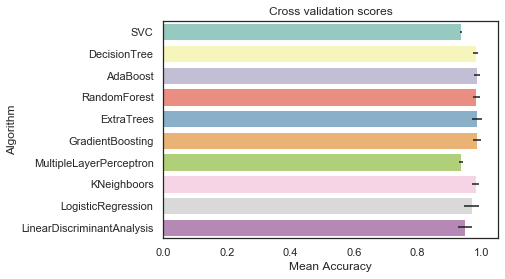

In [20]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [21]:
print(cv_means)

[0.9358431516936673, 0.9833762886597939, 0.9875, 0.985438144329897, 0.987563994670033, 0.9875214776632303, 0.9379264850270005, 0.9834398450101691, 0.9709188056665965, 0.9501924223297566]


In [24]:
#PARAMETER TUNING FOR ADABOOST, EXTRATREES AND GRADIENT BOOSTING

In [25]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING
# Adaboost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  56 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    4.8s finished


In [26]:
gsadaDTC.best_score_

0.9875776397515528

In [27]:
#Extratrees
ExtC = ExtraTreesClassifier()
## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_
# Best score
gsExtC.best_score_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   24.5s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:   35.1s finished


0.989648033126294

In [28]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }
gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_
# Best score
gsGBC.best_score_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.4s
[Parallel(n_jobs=4)]: Done 360 out of 360 | elapsed:   16.6s finished


0.989648033126294

In [35]:
from sklearn import metrics

In [37]:
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")

#Accuracy 
print("Accuracy of Extratrees:",metrics.accuracy_score(test_Survived_ExtC, y_test))
print("Accuracy of AdaBoost:",metrics.accuracy_score(test_Survived_AdaC, y_test))
print("Accuracy of GradientBoosting:",metrics.accuracy_score(test_Survived_GBC, y_test))


Accuracy of Extratrees: 0.9831932773109243
Accuracy of AdaBoost: 0.9747899159663865
Accuracy of GradientBoosting: 0.9747899159663865
